Tasks:

- retrieve ATL03 data for TOC height 2020, 2021 and 2022
- convert it from df > gdf
- clip it to each area defined on QGIS
    - assign projection 32733 to raster
    - batch clip raster with area123 clip layers
    - batch polygonize clipped rasters and save as shapefiles
    - remove nodata [0] values.
- create 10m voxels of the ATL03 poitcloud > downsample to 10m (we lose the columns from point cloud)
- do spatial join to retrieve back information from pointcloud data
- kdtree analysis with Biomass, GCH data for 2020/2021/2022
- export final gdf as csv file with coordinates (XYZ)
- manually filter one track using QGIS.
- plot results

In [1]:
from geopandas.tools import sjoin_nearest
from scipy.spatial import cKDTree
from IPython.display import Image
import geopandas as gpd
from pyproj import CRS
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


from raster_functions import *
EPSG_Namibia_Code = 32733

/tmp/ipykernel_184792/1060763125.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  from geopandas.tools import sjoin_nearest


- retrieve ATL03 data for TOC height 2020 and 2021

In [2]:
%%time

directory = '/DATA/magalhaes/icesat2_atl03/atl03_hdf_window/'

file_pattern = ['ATL03_TOC', 'ATL03_Grass']
start_date = '2020-01-01'
nmonths = 27 # select 2 years: 2020, 2021, 2022

dfs_list = merge_df_nmonths(directory, start_date, nmonths, file_pattern)

CPU times: user 21.6 s, sys: 3.17 s, total: 24.8 s
Wall time: 40.9 s


- convert it from df > gdf

In [3]:
gdf_TOC, gdf_Grass = convert_to_geodataframe(dfs_list)

In [4]:
gdf_TOC.shape

(11888223, 18)

- clip it to each area defined on QGIS

In [5]:
area_paths = ['../raster_analysis/kdtree_areas/areas_latest/area1/area1.geojson',
              '../raster_analysis/kdtree_areas/areas_latest/area2.geojson',
              '../raster_analysis/kdtree_areas/areas_latest/area3/area3.geojson']

clipped_gdfs = []
for path in area_paths:
    with open(path) as f:
        clip_gdf = gpd.read_file(f)
    gdf_TOC.loc[gdf_TOC.intersects(clip_gdf.unary_union), 'clipped'] = True
    clipped_gdf = gdf_TOC[gdf_TOC['clipped'] == True].copy()
    clipped_gdfs.append(clipped_gdf)
    gdf_TOC.drop('clipped', axis=1, inplace=True)

# Access the clipped GeoDataFrames as clipped_gdfs[0], clipped_gdfs[1], etc.
area1_TOC = clipped_gdfs[0]
area2_TOC = clipped_gdfs[1]
area3_TOC = clipped_gdfs[2]

In [6]:
area_paths = ['../raster_analysis/kdtree_areas/areas_latest/area1/area1.geojson',
              '../raster_analysis/kdtree_areas/areas_latest/area2.geojson',
              '../raster_analysis/kdtree_areas/areas_latest/area3/area3.geojson']

clipped_gdfs = []
for path in area_paths:
    with open(path) as f:
        clip_gdf = gpd.read_file(f)
    gdf_Grass.loc[gdf_Grass.intersects(clip_gdf.unary_union), 'clipped'] = True
    clipped_gdf = gdf_Grass[gdf_Grass['clipped'] == True].copy()
    clipped_gdfs.append(clipped_gdf)
    gdf_Grass.drop('clipped', axis=1, inplace=True)

# Access the clipped GeoDataFrames as clipped_gdfs[0], clipped_gdfs[1], etc.
area1_Grass = clipped_gdfs[0]
area2_Grass = clipped_gdfs[1]
area3_Grass = clipped_gdfs[2]

In [7]:
area1_TOC.shape, area2_TOC.shape, area3_TOC.shape

((16002, 19), (7043, 19), (21971, 19))

In [8]:
area1_Grass.shape, area2_Grass.shape, area3_Grass.shape

((15882, 18), (6468, 18), (25173, 18))

In [9]:
del dfs_list, gdf_Grass, gdf_TOC

- create 10m voxels of the ATL03 poitcloud > downsample to 10m

In [10]:
def voxelize_gdf(gdf, voxel_size):
    """
    Function that takes a point clound gdf with geometry xyz and creates voxels of defined size.
    
    """
    # Define TOC_Height as z in the geometry column xy 
    gdf['geometry'] = gdf.apply(lambda row: Point(row.geometry.x, row.geometry.y, row.TOC_Height), axis=1)
    
    # Determine the bounds of the point cloud data in X, Y, and Z dimensions
    xmin, ymin = gdf.total_bounds[:2]
    xmax, ymax = gdf.total_bounds[2:]
    zmin = np.amin(gdf.geometry.apply(lambda p: p.z))
    zmax = np.amax(gdf.geometry.apply(lambda p: p.z))

    # Calculate the number of voxels needed in each dimension
    xdim = int(np.ceil((xmax - xmin) / 10))
    ydim = int(np.ceil((ymax - ymin) / 10))
    zdim = int(np.ceil((zmax - zmin) / 10))

    # Create an empty voxel grid with dimensions equal to the number of voxels needed in each dimension
    voxels = np.zeros((xdim, ydim, zdim))
    zvalues = []

    # Iterate through each point in the point cloud data, and assign it to the appropriate voxel in the grid
    for i, row in gdf.iterrows():
        x, y, z = row['geometry'].x, row['geometry'].y, row['geometry'].z
        xidx = int((x - xmin) // 10)
        yidx = int((y - ymin) // 10)
        zidx = int((z - zmin) // 10)
        voxels[xidx, yidx, zidx] += 1
        zvalues.append(z)

    # Calculate the median Z value for each voxel
    zmedian = np.zeros((xdim, ydim, zdim))
    for xidx in range(xdim):
        for yidx in range(ydim):
            for zidx in range(zdim):
                if voxels[xidx, yidx, zidx] > 0:
                    zvals = []
                    for i in range(int(voxels[xidx, yidx, zidx])):
                        zvals.append(zvalues.pop(0))
                    zmedian[xidx, yidx, zidx] = np.median(zvals)

    # Convert the voxel grid to a GeoDataFrame
    points = []
    for xidx in range(xdim):
        for yidx in range(ydim):
            for zidx in range(zdim):
                if voxels[xidx, yidx, zidx] > 0:
                    x = xmin + (xidx + 0.5) * 10
                    y = ymin + (yidx + 0.5) * 10
                    z = zmin + (zidx + 0.5) * 10
                    zmed = zmedian[xidx, yidx, zidx]
                    point = Point(x, y, zmed)
                    points.append(point)
    gdf_voxels = gpd.GeoDataFrame(geometry=points)

    return gdf_voxels

In [11]:
area1_TOC_voxels = voxelize_gdf(gdf=area1_TOC, voxel_size=10)
area2_TOC_voxels = voxelize_gdf(gdf=area2_TOC, voxel_size=10)
area3_TOC_voxels = voxelize_gdf(gdf=area3_TOC, voxel_size=10)

crs = CRS.from_epsg(EPSG_Namibia_Code)
area1_TOC_voxels.crs = crs
area2_TOC_voxels.crs = crs
area3_TOC_voxels.crs = crs

In [12]:
area1_TOC = sjoin_nearest(area1_TOC_voxels, area1_TOC, distance_col='distance')
area2_TOC = sjoin_nearest(area2_TOC_voxels, area2_TOC, distance_col='distance')
area3_TOC = sjoin_nearest(area3_TOC_voxels, area3_TOC, distance_col='distance')

In [13]:
# check maximum distance of spatial join nearest neighbour
area1_TOC['distance'].max(), area2_TOC['distance'].max(), area3_TOC['distance'].max()

(7.047764915861145, 7.00506419559445, 7.032120830308241)

- kdtree analysis with Biomass, GCH data for 2020/2021

In [14]:
def kdtree_comparison(point_gdf, polygon_gdf, polygon_column_name, new_column_name):
    # Create a k-d tree from the polygons in the polygon GeoDataFrame
    polygon_tree = cKDTree(np.array([np.array(x.centroid.coords)[0] for x in polygon_gdf.geometry]))

    # Find the nearest polygon to each point in the point GeoDataFrame
    distances, indices = polygon_tree.query(np.array([np.array(x.coords)[0] for x in point_gdf.geometry]), k=1)

    # Add a new column to the point GeoDataFrame with the value from the nearest polygon
    point_gdf[new_column_name] = polygon_gdf.iloc[indices][polygon_column_name].values

    # Return the updated point GeoDataFrame
    return point_gdf

In [15]:
# Remove z from geometry xyz for KDTree analysis
area1_TOC['geometry'] = area1_TOC.apply(lambda row: Point(row.geometry.x, row.geometry.y), axis=1)
area2_TOC['geometry'] = area2_TOC.apply(lambda row: Point(row.geometry.x, row.geometry.y), axis=1)
area3_TOC['geometry'] = area3_TOC.apply(lambda row: Point(row.geometry.x, row.geometry.y), axis=1)

In [16]:
# Read files as geodataframe
biomass_area1 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/area1_AGB.shp')
gch_area1 = gpd.read_file('../raster_analysis/kdtree_areas/gch_area1.shp')

# Run KDTree analysis for each dataset
area1_TOC_biomass = kdtree_comparison(area1_TOC, biomass_area1, 'biomass', 'biomass')
area1_TOC_biomass_gch = kdtree_comparison(area1_TOC_biomass, gch_area1, 'gch_m', 'gch_m')


In [17]:
biomass_area1 = biomass_area1.to_crs(EPSG_Namibia_Code)
gch_area1 = gch_area1.to_crs(EPSG_Namibia_Code)

In [18]:
# Read files as geodataframe
biomass_area2 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/area2_redo/AGB_area2.shp')
gch_area2 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/area2_redo/gch_area2.shp')


In [19]:
biomass_area2 = biomass_area2.to_crs(EPSG_Namibia_Code)

In [20]:

# Run KDTree analysis for each dataset
area2_TOC_biomass = kdtree_comparison(area2_TOC, biomass_area2, 'biomass', 'biomass')
area2_TOC_biomass_gch = kdtree_comparison(area2_TOC_biomass, gch_area2, 'gch_m', 'gch_m')


In [21]:
# Read files as geodataframe
biomass_area3 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/AGB_area3.shp')
gch_area3 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/GCH/area3_gch.shp')


In [22]:
biomass_area3 = biomass_area3.to_crs(EPSG_Namibia_Code)

In [23]:
area2_TOC_biomass_gch.head()

,geometry,index_right,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,...,x,NN,Photons_Numb,Date,easting_sq,northing_sq,clipped,distance,biomass,gch_m
0,POINT (416279.838 8085407.276),701849,-17.315150,14.212170,18.774075,4.0,416280.096247,8.085410e+06,2586.163198,1.078492e+06,...,0.895107,34.0,2.0,2021-05-19,416,8085,True,2.347633,0.686474,0.0
1,POINT (416279.838 8085457.276),701873,-17.314703,14.212124,8.490439,4.0,416274.992622,8.085459e+06,2586.133059,1.078542e+06,...,0.895257,63.0,1.0,2021-05-19,416,8085,True,5.184520,0.676830,0.0
2,POINT (416289.838 8085287.276),701767,-17.316290,14.212285,12.211633,4.0,416292.830675,8.085284e+06,2585.984662,1.078366e+06,...,0.894727,50.0,3.0,2021-05-19,416,8085,True,4.751395,0.665483,0.0
3,POINT (416289.838 8085327.276),701798,-17.315871,14.212243,18.766144,4.0,416288.184325,8.085330e+06,2586.087933,1.078412e+06,...,0.894867,14.0,3.0,2021-05-19,416,8085,True,3.136693,0.676280,0.0
4,POINT (416289.838 8085337.276),701802,-17.315845,14.212240,1.580280,4.0,416287.836163,8.085333e+06,2586.028637,1.078415e+06,...,0.894875,84.0,1.0,2021-05-19,416,8085,True,4.942701,0.678399,0.0


In [24]:
# Run KDTree analysis for each dataset
area3_TOC_biomass = kdtree_comparison(area3_TOC, biomass_area3, 'biomass', 'biomass')
area3_TOC_biomass_gch = kdtree_comparison(area3_TOC_biomass, gch_area3, 'gch_m', 'gch_m')


In [25]:
# Load the shapefiles with S1 VVdVh data 
s1_area1 = gpd.read_file('../raster_analysis/kdtree_areas/shapefiles/VVdVH_med_Oct_2018_Mar_2022_s1_area1.shp')
s1_area2 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/area2_redo/s1_area2.shp')
s1_area3 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/s1_area3.shp')

In [26]:
s1_area2 = s1_area2.to_crs(EPSG_Namibia_Code)
s1_area1 = s1_area1.to_crs(EPSG_Namibia_Code)
s1_area3 = s1_area3.to_crs(EPSG_Namibia_Code)

In [27]:
# Use KDTree to retrieve closest grass height values
area1 = kdtree_comparison(area1_TOC_biomass_gch, s1_area1, 's1_median', 'S1_VVdVH_median')
area2 = kdtree_comparison(area2_TOC_biomass_gch, s1_area2, 's1_median', 'S1_VVdVH_median')
area3 = kdtree_comparison(area3_TOC_biomass_gch, s1_area3, 's1_median', 'S1_VVdVH_median')

- export final gdf for QGIS filtering


In [28]:
area1.to_file('../raster_analysis/kdtree_areas/areas_latest/outputs/area1_TOC_biomass_gch.geojson', driver='GeoJSON')
area2.to_file('../raster_analysis/kdtree_areas/areas_latest/outputs/area2_TOC_biomass_gch.geojson', driver='GeoJSON')
area3.to_file('../raster_analysis/kdtree_areas/areas_latest/outputs/area3_TOC_biomass_gch.geojson', driver='GeoJSON')

In [39]:
area1.head()

,geometry,index_right,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,...,NN,Photons_Numb,Date,easting_sq,northing_sq,clipped,distance,biomass,gch_m,S1_VVdVH_median
0,POINT (536476.540 7823154.092),5997176,-19.686674,15.347974,9.430696,0.0,536471.540333,7.823153e+06,2466.323778,2.187517e+06,...,44.0,7.0,2020-12-10,536,7823,True,5.036923,0.0,2,0.697746
1,POINT (536476.540 7823154.092),5997176,-19.686674,15.347974,9.430696,0.0,536471.540333,7.823153e+06,2466.323778,2.187517e+06,...,44.0,7.0,2020-12-10,536,7823,True,5.036923,0.0,2,0.697746
2,POINT (536476.540 7823174.092),5997039,-19.686482,15.347993,8.205918,0.0,536473.543657,7.823175e+06,2466.475254,2.187495e+06,...,11.0,3.0,2020-12-10,536,7823,True,3.043647,0.0,1,0.696060
3,POINT (536476.540 7823184.092),5996987,-19.686400,15.348001,19.021019,0.0,536474.430945,7.823184e+06,2466.521395,2.187486e+06,...,7.0,4.0,2020-12-10,536,7823,True,2.132072,0.0,1,0.699580
4,POINT (536476.540 7823194.092),5996884,-19.686272,15.348016,4.821840,0.0,536476.010693,7.823198e+06,2466.380640,2.187472e+06,...,38.0,3.0,2020-12-10,536,7823,True,3.832702,0.0,1,0.704632


In [30]:
area2.head()

,geometry,index_right,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,...,NN,Photons_Numb,Date,easting_sq,northing_sq,clipped,distance,biomass,gch_m,S1_VVdVH_median
0,POINT (416279.838 8085407.276),701849,-17.315150,14.212170,18.774075,4.0,416280.096247,8.085410e+06,2586.163198,1.078492e+06,...,34.0,2.0,2021-05-19,416,8085,True,2.347633,0.686474,0.0,0.686474
1,POINT (416279.838 8085457.276),701873,-17.314703,14.212124,8.490439,4.0,416274.992622,8.085459e+06,2586.133059,1.078542e+06,...,63.0,1.0,2021-05-19,416,8085,True,5.184520,0.676830,0.0,0.676830
2,POINT (416289.838 8085287.276),701767,-17.316290,14.212285,12.211633,4.0,416292.830675,8.085284e+06,2585.984662,1.078366e+06,...,50.0,3.0,2021-05-19,416,8085,True,4.751395,0.665483,0.0,0.665483
3,POINT (416289.838 8085327.276),701798,-17.315871,14.212243,18.766144,4.0,416288.184325,8.085330e+06,2586.087933,1.078412e+06,...,14.0,3.0,2021-05-19,416,8085,True,3.136693,0.676280,0.0,0.676280
4,POINT (416289.838 8085337.276),701802,-17.315845,14.212240,1.580280,4.0,416287.836163,8.085333e+06,2586.028637,1.078415e+06,...,84.0,1.0,2021-05-19,416,8085,True,4.942701,0.678399,0.0,0.678399


In [31]:
area3.head()

,geometry,index_right,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,...,NN,Photons_Numb,Date,easting_sq,northing_sq,clipped,distance,biomass,gch_m,S1_VVdVH_median
0,POINT (513637.058 7951160.069),15344690,-18.530101,15.129250,8.617517,0.0,513641.241885,7.951160e+06,4484.408495,940785.151451,...,34.0,5.0,2021-10-15,513,7951,True,4.203828,0.0,0.0,0.690758
1,POINT (513637.058 7951170.069),15344777,-18.529973,15.129240,2.803650,0.0,513640.207894,7.951174e+06,4484.783184,940799.357403,...,101.0,3.0,2021-10-15,513,7951,True,4.909620,0.0,0.0,0.688328
2,POINT (513637.058 7951180.069),15344818,-18.529921,15.129236,8.493458,1.0,513639.792811,7.951180e+06,4484.932169,940805.045848,...,113.0,2.0,2021-10-15,513,7951,True,2.791494,0.0,0.0,0.684936
3,POINT (513637.058 7951200.069),15344916,-18.529762,15.129218,6.249567,0.0,513637.893511,7.951197e+06,4484.792361,940822.819756,...,76.0,6.0,2021-10-15,513,7951,True,3.004775,0.0,0.0,0.687557
4,POINT (513637.058 7951200.069),15344916,-18.529762,15.129218,6.249567,0.0,513637.893511,7.951197e+06,4484.792361,940822.819756,...,76.0,6.0,2021-10-15,513,7951,True,3.004775,0.0,0.0,0.687557


In [40]:
del area1_TOC_biomass_gch, area2_TOC_biomass_gch, area3_TOC_biomass_gch, area1_TOC_biomass, area2_TOC_biomass, area3_TOC_biomass, area1_TOC_voxels, area2_TOC_voxels, area3_TOC_voxels, area1_TOC, area2_TOC, area3_TOC

- plot results

#### After Filtering on QGIS

In [38]:
# Load the GeoJSON file as a GeoDataFrame
area1 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/outputs/area1_TOC_biomass_gch.geojson')
area2 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/outputs/area2_TOC_biomass_gch.geojson')
area3 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/outputs/area3_TOC_biomass_gch.geojson')

In [41]:
area1 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/outputs/Area1_AGB_FINAL.shp')

In [46]:
area3['biomass'].unique()

array([0., 1., 2.])

In [42]:
area1.shape, area2.shape, area3.shape

((14568, 26), (6290, 24), (18638, 24))

In [43]:
area1.head()

,index_righ,Latitude,Longitude,Along-trac,Land,Easting,Northing,crosstrack,alongtrack,Ground_int,...,easting_sq,northing_s,clipped,distance,biomass1,gch_m,S1_VVdVH_m,s1_med,biomass,geometry
0,5997176,-19.686674,15.347974,9.430696,0.0,536471.540333,7.823153e+06,2466.323778,2.187517e+06,1246.495720,...,536,7823,1,5.036923,0.0,2,0.697746,0.69115,0.0,POINT (536476.540 7823154.092)
1,5997176,-19.686674,15.347974,9.430696,0.0,536471.540333,7.823153e+06,2466.323778,2.187517e+06,1246.495720,...,536,7823,1,5.036923,0.0,2,0.697746,0.69115,0.0,POINT (536476.540 7823154.092)
2,5997039,-19.686482,15.347993,8.205918,0.0,536473.543657,7.823175e+06,2466.475254,2.187495e+06,1246.560973,...,536,7823,1,3.043647,0.0,1,0.696060,0.69250,0.0,POINT (536476.540 7823174.092)
3,5996987,-19.686400,15.348001,19.021019,0.0,536474.430945,7.823184e+06,2466.521395,2.187486e+06,1246.600063,...,536,7823,1,2.132072,0.0,1,0.699580,0.69577,0.0,POINT (536476.540 7823184.092)
4,5996884,-19.686272,15.348016,4.821840,0.0,536476.010693,7.823198e+06,2466.380640,2.187472e+06,1246.657741,...,536,7823,1,3.832702,0.0,1,0.704632,0.69806,0.0,POINT (536476.540 7823194.092)


- Adding Grass Height to gdf of each area

In [47]:
# Use KDTree to retrieve closest grass height values
area1 = kdtree_comparison(area1, area1_Grass, 'Grass_Height', 'Grass_Height')
area2 = kdtree_comparison(area2, area2_Grass, 'Grass_Height', 'Grass_Height')
area3 = kdtree_comparison(area3, area3_Grass, 'Grass_Height', 'Grass_Height')

In [48]:
del area1_Grass, area2_Grass, area3_Grass

In [49]:
area2.head()

,geometry,index_right,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,...,Photons_Numb,Date,easting_sq,northing_sq,clipped,distance,biomass,gch_m,S1_VVdVH_median,Grass_Height
0,POINT (416279.838 8085407.276),701849,-17.315150,14.212170,18.774075,4.0,416280.096247,8.085410e+06,2586.163198,1.078492e+06,...,2.0,2021-05-19,416,8085,True,2.347633,0.686474,0.0,0.686474,0.500859
1,POINT (416279.838 8085457.276),701873,-17.314703,14.212124,8.490439,4.0,416274.992622,8.085459e+06,2586.133059,1.078542e+06,...,1.0,2021-05-19,416,8085,True,5.184520,0.676830,0.0,0.676830,2.845234
2,POINT (416289.838 8085287.276),701767,-17.316290,14.212285,12.211633,4.0,416292.830675,8.085284e+06,2585.984662,1.078366e+06,...,3.0,2021-05-19,416,8085,True,4.751395,0.665483,0.0,0.665483,2.967093
3,POINT (416289.838 8085327.276),701798,-17.315871,14.212243,18.766144,4.0,416288.184325,8.085330e+06,2586.087933,1.078412e+06,...,3.0,2021-05-19,416,8085,True,3.136693,0.676280,0.0,0.676280,2.159778
4,POINT (416289.838 8085337.276),701802,-17.315845,14.212240,1.580280,4.0,416287.836163,8.085333e+06,2586.028637,1.078415e+06,...,1.0,2021-05-19,416,8085,True,4.942701,0.678399,0.0,0.678399,2.159778


In [23]:
area1.to_file('../raster_analysis/kdtree_areas/areas_latest/outputs/area1_TOC_biomass_gch.geojson', driver='GeoJSON')
area2.to_file('../raster_analysis/kdtree_areas/areas_latest/outputs/area2_TOC_biomass_gch.geojson', driver='GeoJSON')
area3.to_file('../raster_analysis/kdtree_areas/areas_latest/outputs/area3_TOC_biomass_gch.geojson', driver='GeoJSON')

In [68]:
# Load the GeoJSON file as a GeoDataFrame
area1 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/outputs/filtered/filtered/area1_TOC_biomass_gch_s1.geojson')
area2 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/outputs/filtered/filtered/area2_TOC_biomass_gch.geojson')
area3 = gpd.read_file('../raster_analysis/kdtree_areas/areas_latest/outputs/filtered/filtered/area3_TOC_biomass_gch.geojson')

#### Area1

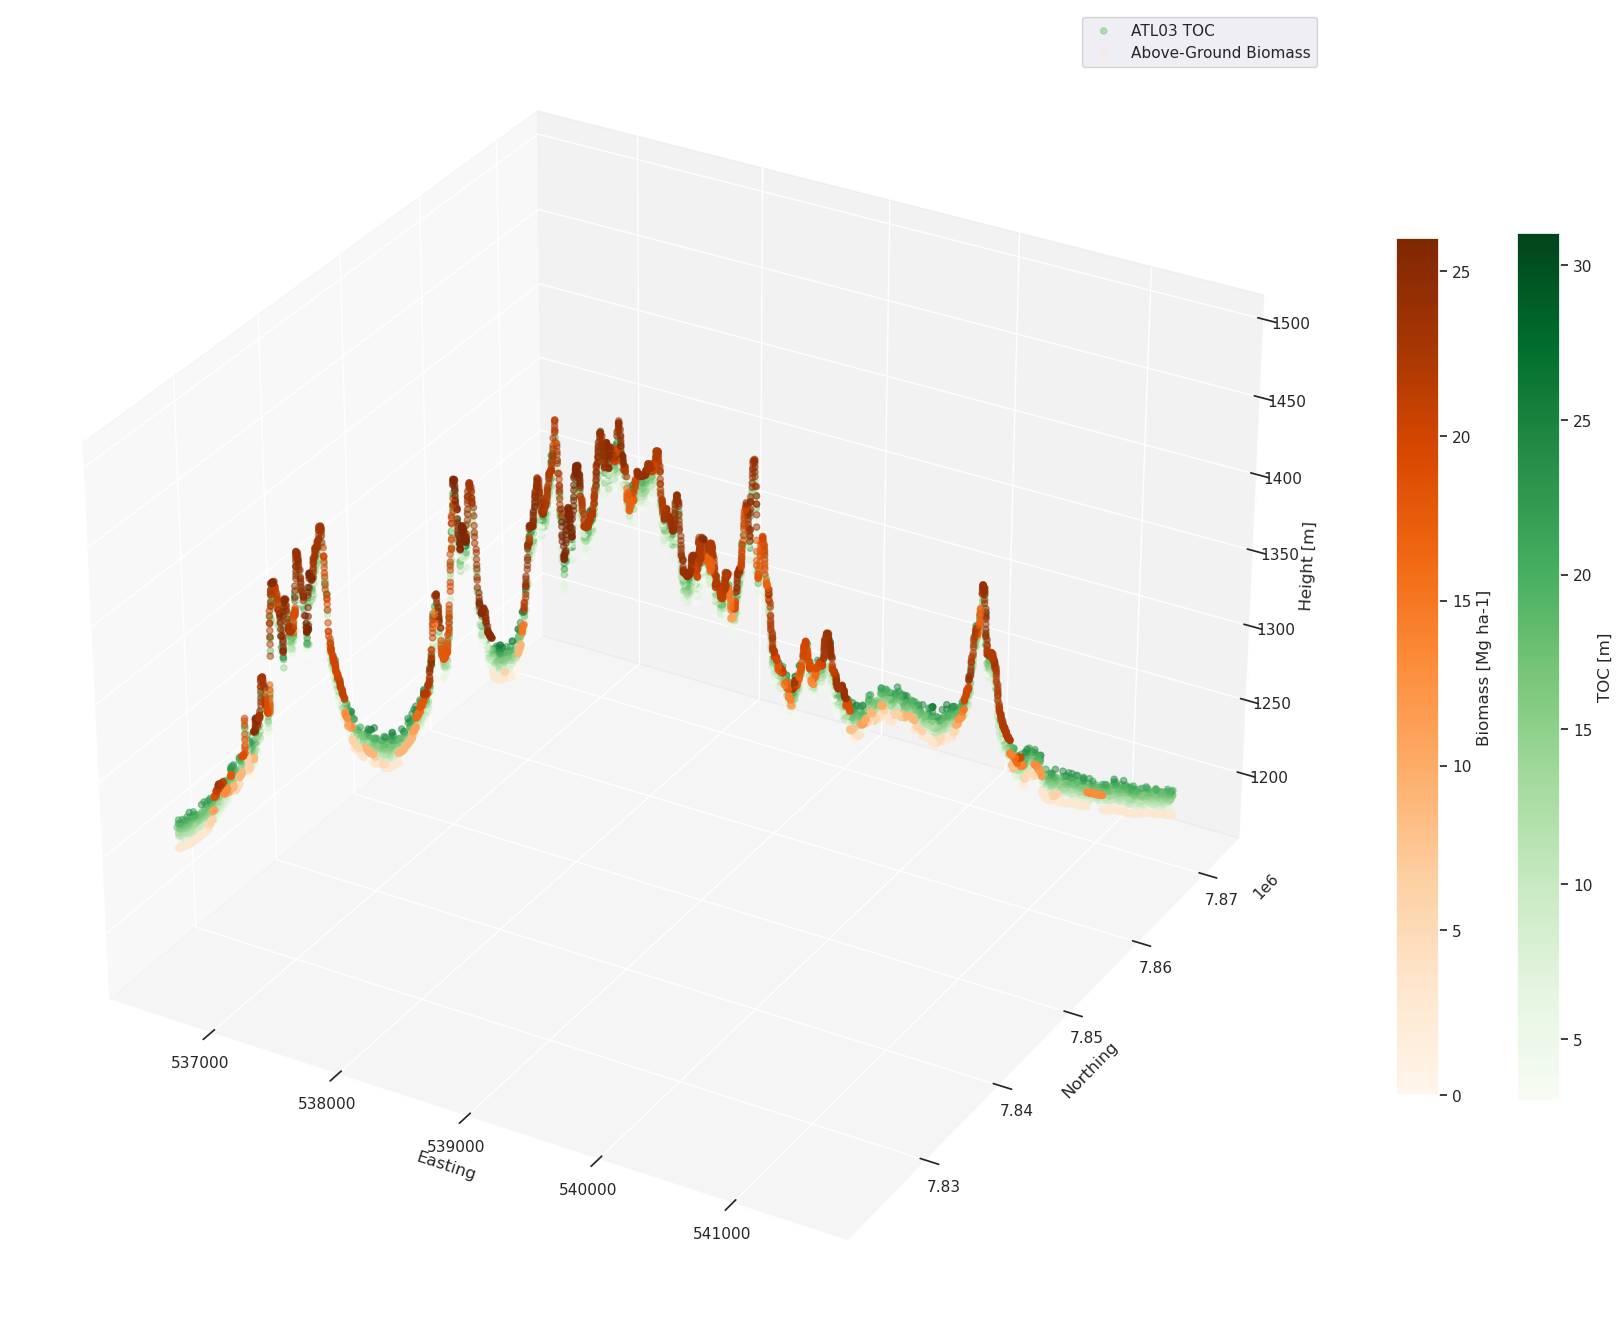

In [71]:
import matplotlib.cm as cm
import matplotlib as mpl

# Create a 3D figure and axis
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Set the font size for all elements of the plot
mpl.rcParams.update({'font.size': 12})

# Set the plot background color to white
ax.set_facecolor('white')

# Extract the X, Y, and Z coordinates from the geometry column
x = area1.geometry.x
y = area1.geometry.y
z = (area1.TOC_Height + area1.Ground_interp_Height)
v = (area1.biomass + area1.Ground_interp_Height)

# Set the marker size based on a column of the GeoDataFrame
size_column = 'TOC_Height'
size = area1[size_column] 
scaled_size = size / size.max() * 100 # Scale the size to be between 0 and 100

# Create a colorbar based on the size variable
sm = plt.cm.ScalarMappable(cmap=cm.Greens, norm=plt.Normalize(vmin=size.min(), vmax=size.max()))
sm._A = []
cbar2 = plt.colorbar(sm, fraction=0.028)
cbar2.set_label('TOC [m]')

# Set the marker size based on a column of the GeoDataFrame
size_column = 'biomass'
size = area1[size_column] 
scaled_size3 = size / size.max() * 100 # Scale the size to be between 0 and 100

# Create a colorbar based on the size variable
sm = plt.cm.ScalarMappable(cmap=cm.Oranges, norm=plt.Normalize(vmin=size.min(), vmax=size.max()))
sm._A = []
cbar = plt.colorbar(sm, fraction=0.03)
cbar.set_label('Biomass [Mg ha-1]')

# Plot the points in 3D with marker size based on the specified column
ax.scatter(x, y, z, c=area1['TOC_Height'], alpha=0.5, label='ATL03 TOC', cmap='Greens')#, s=scaled_size)
ax.scatter(x, y, v, c=area1['biomass'], alpha=0.5, label='Above-Ground Biomass', cmap='Oranges')#, s=scaled_size3)

# Set axis labels
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_zlabel('Height [m]')
ax.legend()

# Show the plot
plt.show()

- Scatter plot X (ATL03 data) vs Y (Above ground biomass)

#### Area2

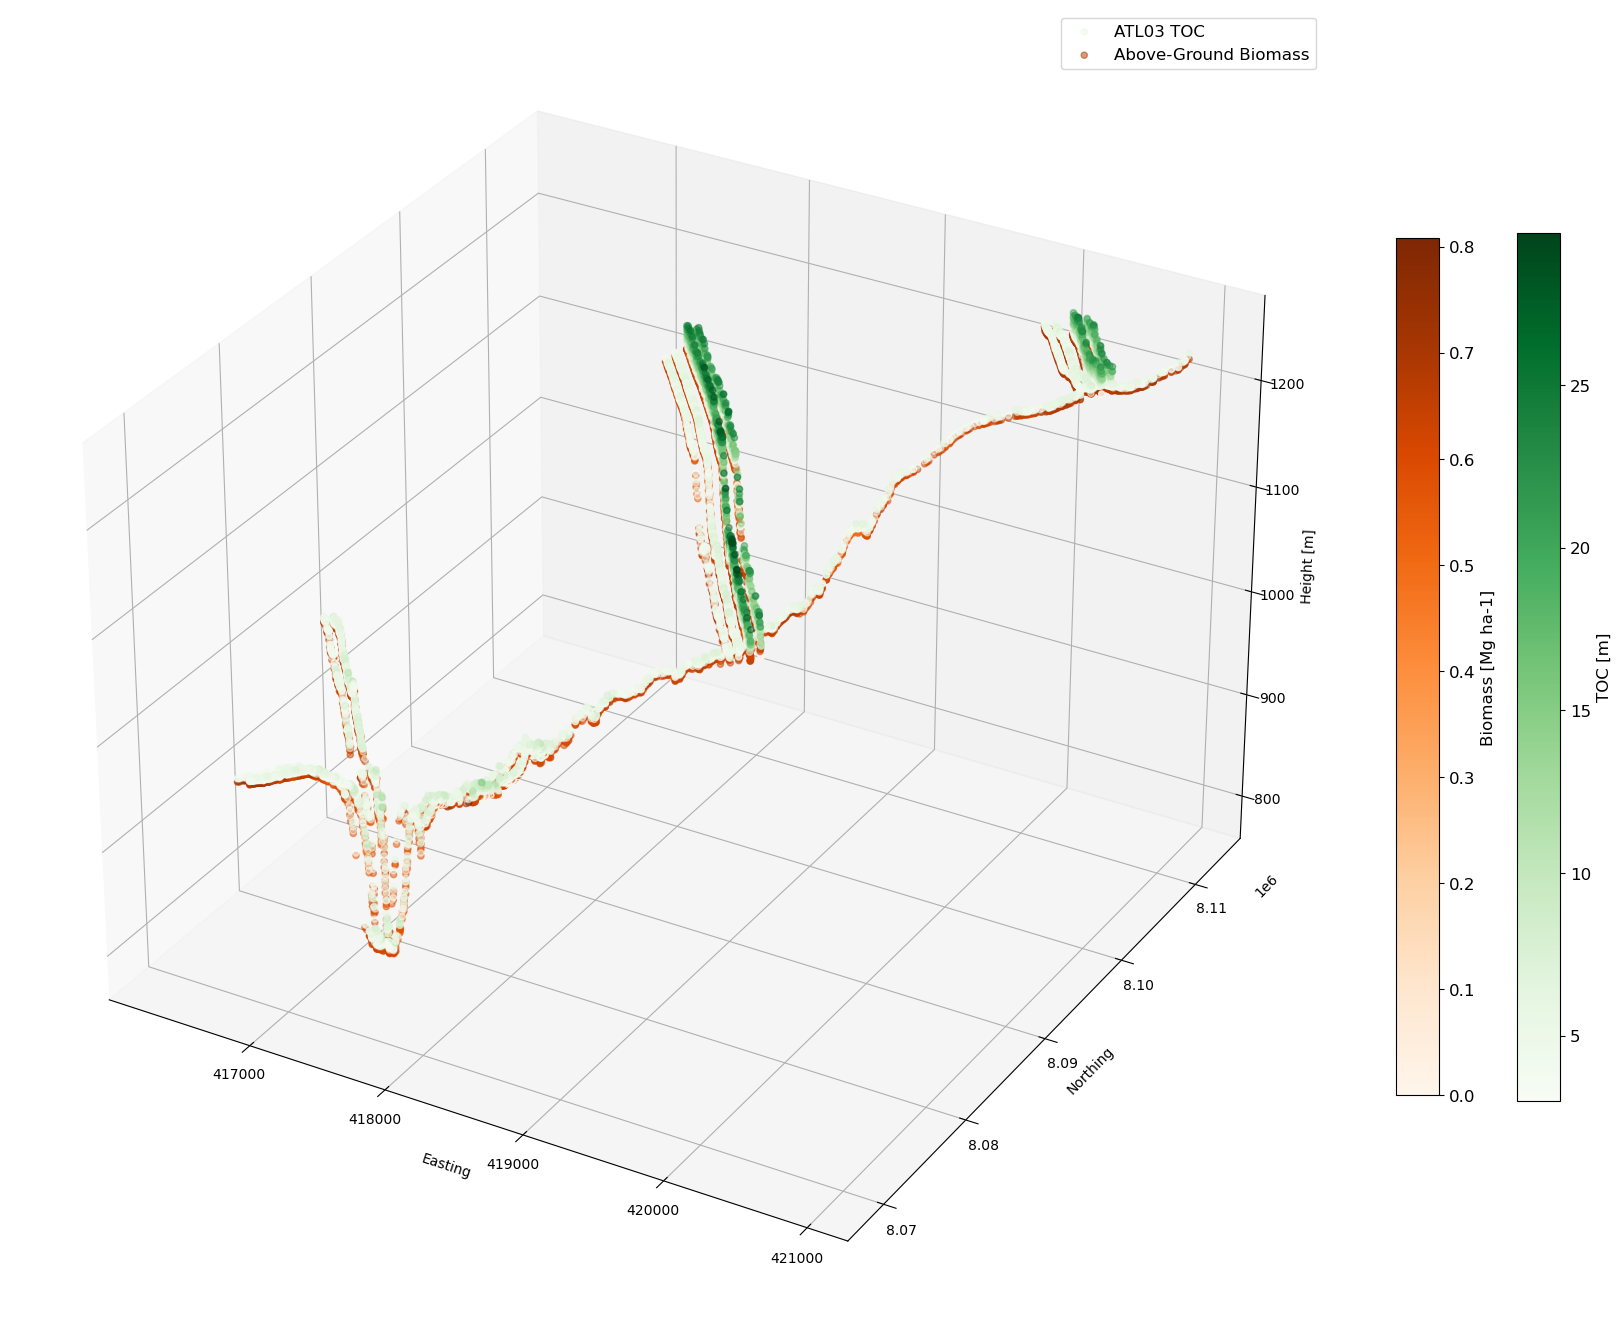

In [50]:
import matplotlib.cm as cm
import matplotlib as mpl

# Create a 3D figure and axis
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Set the font size for all elements of the plot
mpl.rcParams.update({'font.size': 12})

# Set the plot background color to white
ax.set_facecolor('white')

# Extract the X, Y, and Z coordinates from the geometry column
x = area2.geometry.x
y = area2.geometry.y
z = (area2.TOC_Height + area2.Ground_interp_Height)
v = (area2.biomass + area2.Ground_interp_Height)

# Set the marker size based on a column of the GeoDataFrame
size_column = 'TOC_Height'
size = area2[size_column] 
scaled_size = size / size.max() * 100 # Scale the size to be between 0 and 100

# Create a colorbar based on the size variable
sm = plt.cm.ScalarMappable(cmap=cm.Greens, norm=plt.Normalize(vmin=size.min(), vmax=size.max()))
sm._A = []
cbar2 = plt.colorbar(sm, fraction=0.028)
cbar2.set_label('TOC [m]')

# Set the marker size based on a column of the GeoDataFrame
size_column = 'biomass'
size = area2[size_column] 
scaled_size3 = size / size.max() * 100 # Scale the size to be between 0 and 100

# Create a colorbar based on the size variable
sm = plt.cm.ScalarMappable(cmap=cm.Oranges, norm=plt.Normalize(vmin=size.min(), vmax=size.max()))
sm._A = []
cbar = plt.colorbar(sm, fraction=0.03)
cbar.set_label('Biomass [Mg ha-1]')

# Plot the points in 3D with marker size based on the specified column
ax.scatter(x, y, z, c=area2['TOC_Height'], alpha=0.5, label='ATL03 TOC', cmap='Greens')#, s=scaled_size)
ax.scatter(x, y, v, c=area2['biomass'], alpha=0.5, label='Above-Ground Biomass', cmap='Oranges')#, s=scaled_size3)

# Set axis labels
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_zlabel('Height [m]')
ax.legend()

# Show the plot
plt.show()

#### Area3

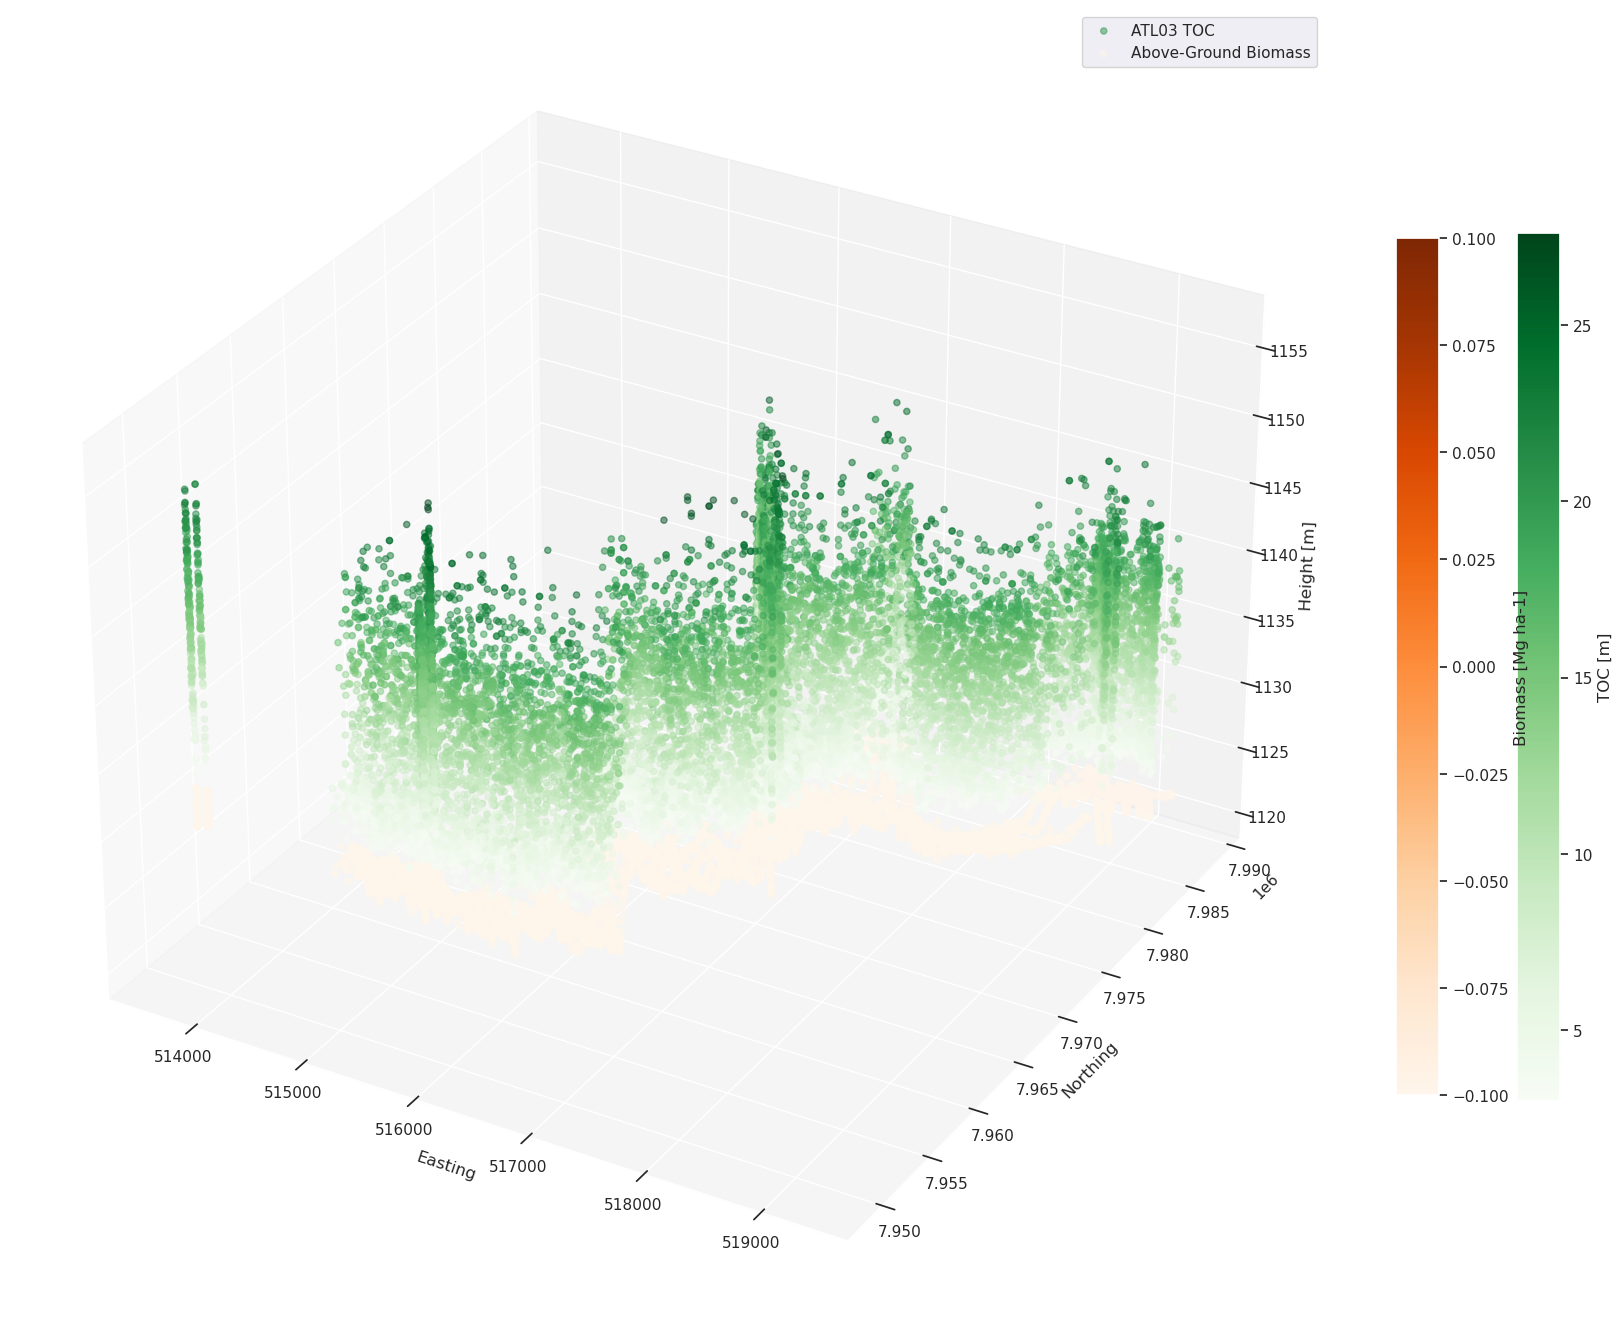

In [74]:
import matplotlib.cm as cm
import matplotlib as mpl

# Create a 3D figure and axis
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Set the font size for all elements of the plot
mpl.rcParams.update({'font.size': 12})

# Set the plot background color to white
ax.set_facecolor('white')

# Extract the X, Y, and Z coordinates from the geometry column
x = area3.geometry.x
y = area3.geometry.y
z = (area3.TOC_Height + area3.Ground_interp_Height)
v = (area3.biomass + area3.Ground_interp_Height)

# Set the marker size based on a column of the GeoDataFrame
size_column = 'TOC_Height'
size = area3[size_column] 
scaled_size = size / size.max() * 100 # Scale the size to be between 0 and 100

# Create a colorbar based on the size variable
sm = plt.cm.ScalarMappable(cmap=cm.Greens, norm=plt.Normalize(vmin=size.min(), vmax=size.max()))
sm._A = []
cbar2 = plt.colorbar(sm, fraction=0.028)
cbar2.set_label('TOC [m]')

# Set the marker size based on a column of the GeoDataFrame
size_column = 'biomass'
size = area3[size_column] 
scaled_size3 = size / size.max() * 100 # Scale the size to be between 0 and 100

# Create a colorbar based on the size variable
sm = plt.cm.ScalarMappable(cmap=cm.Oranges, norm=plt.Normalize(vmin=size.min(), vmax=size.max()))
sm._A = []
cbar = plt.colorbar(sm, fraction=0.03)
cbar.set_label('Biomass [Mg ha-1]')

# Plot the points in 3D with marker size based on the specified column
ax.scatter(x, y, z, c=area3['TOC_Height'], alpha=0.5, label='ATL03 TOC', cmap='Greens')#, s=scaled_size)
ax.scatter(x, y, v, c=area3['biomass'], alpha=0.5, label='Above-Ground Biomass', cmap='Oranges')#, s=scaled_size3)

# Set axis labels
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_zlabel('Height [m]')
ax.legend()

# Show the plot
plt.show()

- Descriptive statistics

In [44]:
# Calculate the descriptive statistics for each column in each area
stats1 = area1[['Grass_Height', 'TOC_Height', 'biomass']].describe().round(2)
stats2 = area2[['Grass_Height', 'TOC_Height', 'biomass']].describe().round(2)
stats3 = area3[['Grass_Height', 'TOC_Height', 'biomass']].describe().round(2)

# Concatenate the statistics for each area into a single table
all_stats = pd.concat([stats1, stats2, stats3], axis=1, keys=['Area 1', 'Area 2', 'Area 3'])

print(all_stats)

            Area 1                            Area 2                     \
      Grass_Height TOC_Height   biomass Grass_Height TOC_Height biomass   
count     14568.00   14568.00  14568.00      6290.00    6290.00  6290.0   
mean          2.06      11.67     16.48         2.16       7.24     0.0   
std           0.69       6.20      8.41         0.72       5.21     0.0   
min           0.50       3.00      0.00         0.50       3.00     0.0   
25%           1.55       5.72      7.00         1.73       4.01     0.0   
50%           2.21      11.54     20.00         2.37       5.09     0.0   
75%           2.65      16.34     24.00         2.74       7.70     0.0   
max           3.00      31.06     26.00         3.00      29.68     0.0   

            Area 3                      
      Grass_Height TOC_Height  biomass  
count     18638.00   18638.00  18638.0  
mean          1.82      10.47      0.0  
std           0.74       5.51      0.0  
min           0.50       3.00      0.0  
25%

In [45]:
# Print the table of descriptive statistics in latex format
latex_table = all_stats.to_latex()
print(latex_table)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Area 1} & \multicolumn{3}{l}{Area 2} & \multicolumn{3}{l}{Area 3} \\
{} & Grass\_Height & TOC\_Height &   biomass & Grass\_Height & TOC\_Height & biomass & Grass\_Height & TOC\_Height &  biomass \\
\midrule
count &     14568.00 &   14568.00 &  14568.00 &      6290.00 &    6290.00 &  6290.0 &     18638.00 &   18638.00 &  18638.0 \\
mean  &         2.06 &      11.67 &     16.48 &         2.16 &       7.24 &     0.0 &         1.82 &      10.47 &      0.0 \\
std   &         0.69 &       6.20 &      8.41 &         0.72 &       5.21 &     0.0 &         0.74 &       5.51 &      0.0 \\
min   &         0.50 &       3.00 &      0.00 &         0.50 &       3.00 &     0.0 &         0.50 &       3.00 &      0.0 \\
25\%   &         1.55 &       5.72 &      7.00 &         1.73 &       4.01 &     0.0 &         1.20 &       4.94 &      0.0 \\
50\%   &         2.21 &      11.54 &     20.00 &         2.37 &       5.09 &     0.0 &         1.87 &

- Correlation matrix

In [46]:
# Calculate the correlation matrices for each area
corr_matrix1 = area1[['Grass_Height', 'TOC_Height', 'biomass']].corr()
corr_matrix2 = area2[['Grass_Height', 'TOC_Height', 'biomass']].corr()
corr_matrix3 = area3[['Grass_Height', 'TOC_Height', 'biomass']].corr()

# Print the correlation matrices for each area
print('Correlation Matrix for Area 1:')
print(corr_matrix1)

print('Correlation Matrix for Area 2:')
print(corr_matrix2)

print('Correlation Matrix for Area 3:')
print(corr_matrix3)

Correlation Matrix for Area 1:
              Grass_Height  TOC_Height   biomass
Grass_Height      1.000000   -0.024998  0.102502
TOC_Height       -0.024998    1.000000 -0.177357
biomass           0.102502   -0.177357  1.000000
Correlation Matrix for Area 2:
              Grass_Height  TOC_Height  biomass
Grass_Height      1.000000    0.024737      NaN
TOC_Height        0.024737    1.000000      NaN
biomass                NaN         NaN      NaN
Correlation Matrix for Area 3:
              Grass_Height  TOC_Height  biomass
Grass_Height      1.000000   -0.033881      NaN
TOC_Height       -0.033881    1.000000      NaN
biomass                NaN         NaN      NaN


In [47]:
# Format the correlation matrices as LaTeX tables
latex_matrix1 = corr_matrix1.to_latex(float_format='%.2f', caption='Correlation Matrix for Area 1')
latex_matrix2 = corr_matrix2.to_latex(float_format='%.2f', caption='Correlation Matrix for Area 2')
latex_matrix3 = corr_matrix3.to_latex(float_format='%.2f', caption='Correlation Matrix for Area 3')

# Print the correlation matrices in LaTeX format
print(latex_matrix1)
print(latex_matrix2)
print(latex_matrix3)

\begin{table}
\centering
\caption{Correlation Matrix for Area 1}
\begin{tabular}{lrrr}
\toprule
{} &  Grass\_Height &  TOC\_Height &  biomass \\
\midrule
Grass\_Height &          1.00 &       -0.02 &     0.10 \\
TOC\_Height   &         -0.02 &        1.00 &    -0.18 \\
biomass      &          0.10 &       -0.18 &     1.00 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\centering
\caption{Correlation Matrix for Area 2}
\begin{tabular}{lrrr}
\toprule
{} &  Grass\_Height &  TOC\_Height &  biomass \\
\midrule
Grass\_Height &          1.00 &        0.02 &      NaN \\
TOC\_Height   &          0.02 &        1.00 &      NaN \\
biomass      &           NaN &         NaN &      NaN \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\centering
\caption{Correlation Matrix for Area 3}
\begin{tabular}{lrrr}
\toprule
{} &  Grass\_Height &  TOC\_Height &  biomass \\
\midrule
Grass\_Height &          1.00 &       -0.03 &      NaN \\
TOC\_Height   &         -0.03 &        1.00 &      NaN \

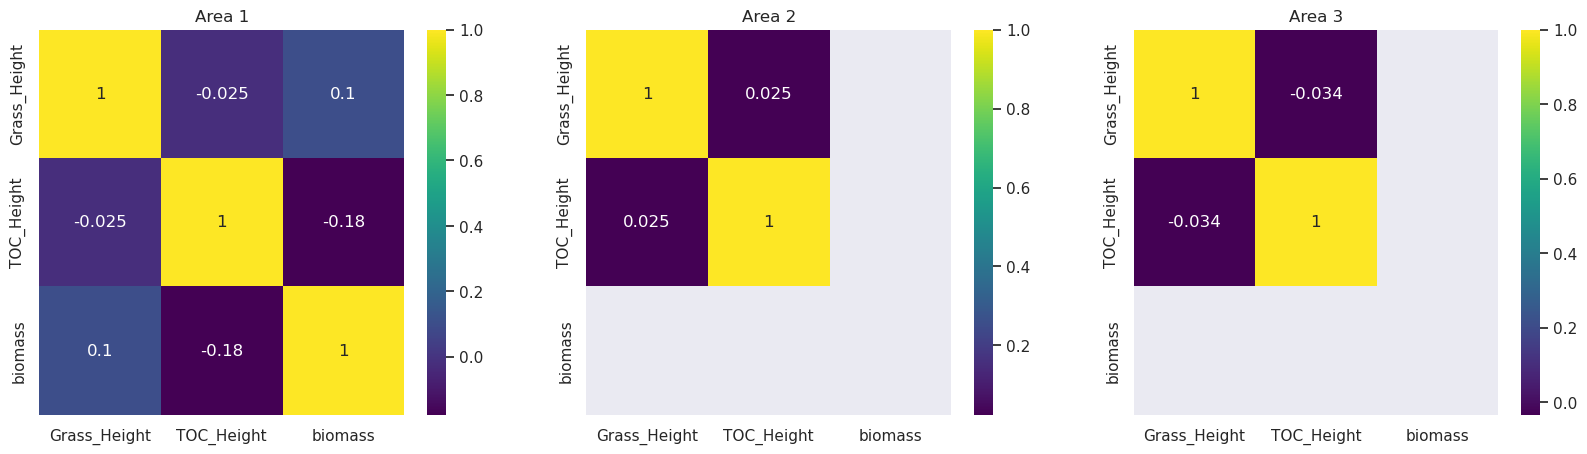

In [48]:
# Create a heatmap of the correlation matrix for each area
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.heatmap(corr_matrix1, annot=True, cmap='viridis', ax=axs[0]).set_title('Area 1')
sns.heatmap(corr_matrix2, annot=True, cmap='viridis', ax=axs[1]).set_title('Area 2')
sns.heatmap(corr_matrix3, annot=True, cmap='viridis', ax=axs[2]).set_title('Area 3')

# Show the plot
plt.show()

- Regression analysis:

In [49]:
import statsmodels.api as sm

# Define the dependent variable (y) and independent variables (X)
y = area1['biomass']
X = area1[['Grass_Height', 'TOC_Height']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                biomass   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     312.0
Date:                Sun, 14 May 2023   Prob (F-statistic):          2.16e-133
Time:                        16:21:34   Log-Likelihood:                -51391.
No. Observations:               14568   AIC:                         1.028e+05
Df Residuals:                   14565   BIC:                         1.028e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           16.7753      0.254     66.121   

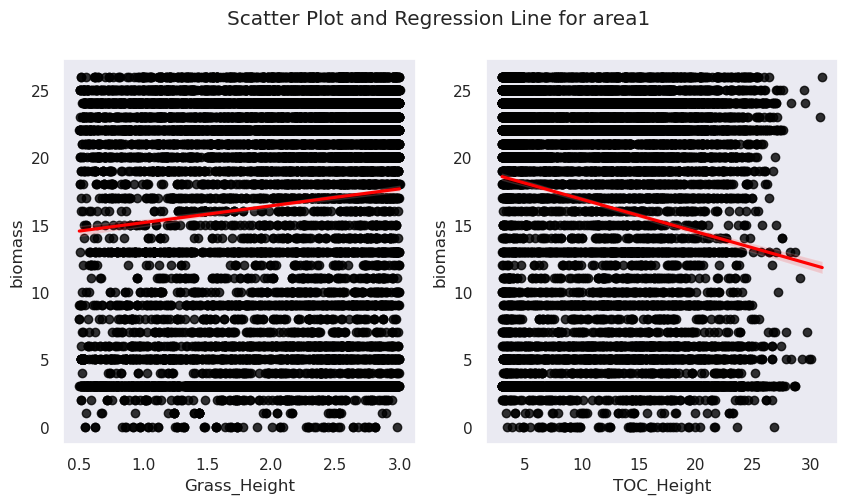

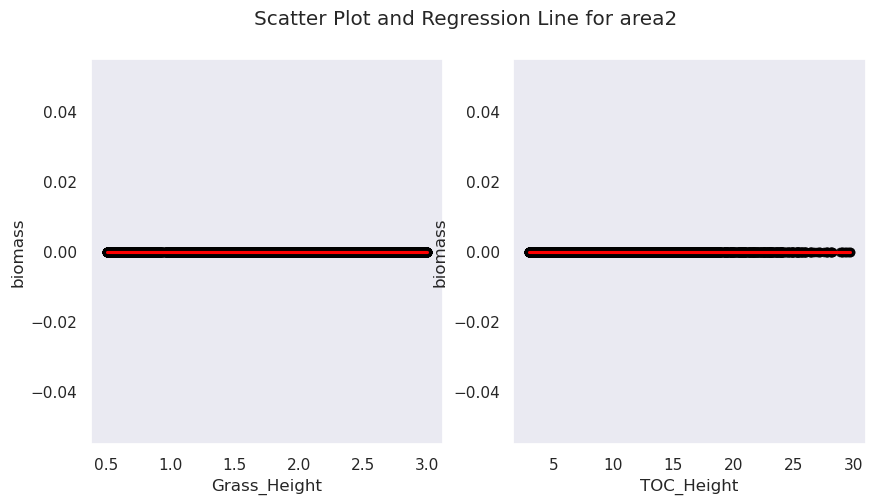

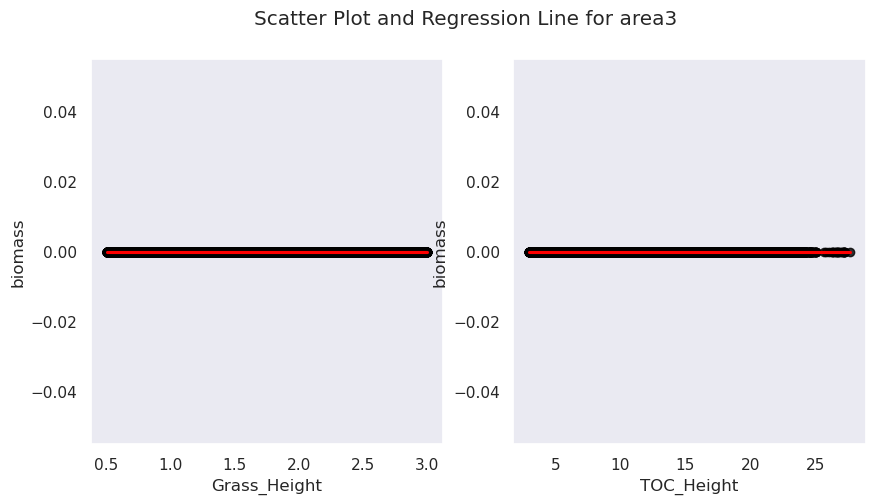

In [50]:
# Create scatter plots and regression lines for the dependent and independent variables for each area
for area in [area1, area2, area3]:
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    sns.regplot(x='Grass_Height', y='biomass', data=area, ax=axs[0], line_kws={'color': 'red'}, scatter_kws={'color': 'black'})
    sns.regplot(x='TOC_Height', y='biomass', data=area, ax=axs[1], line_kws={'color': 'red'}, scatter_kws={'color': 'black'})
    gdf_name = [name for name in globals() if globals()[name] is area][0]
    fig.suptitle(f'Scatter Plot and Regression Line for {gdf_name}')
    plt.show()

- Histogram to compare the distribution of the three variables

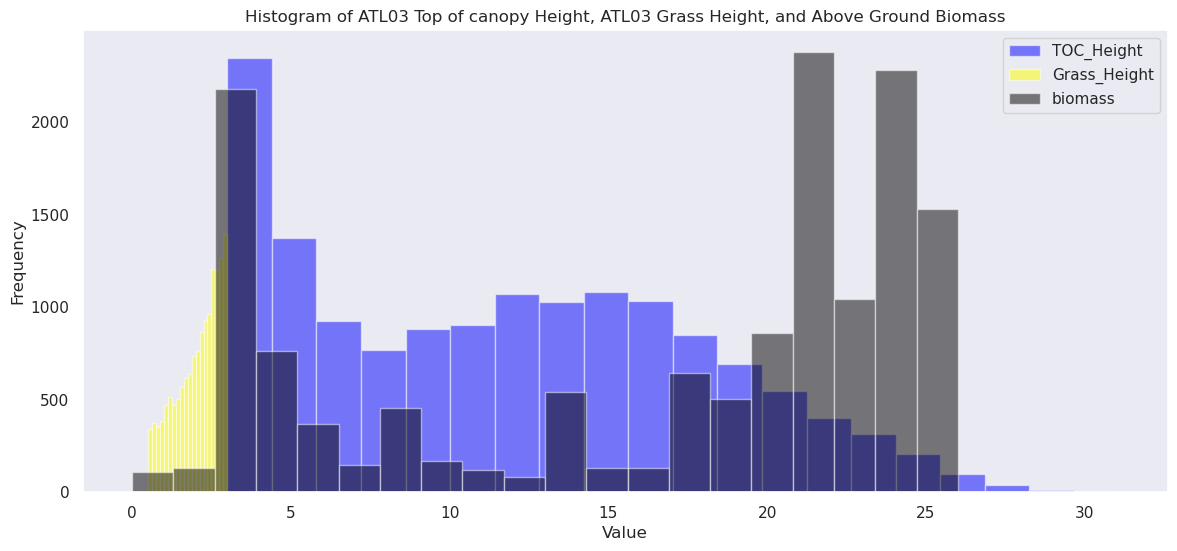

In [51]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.hist(area1['TOC_Height'], bins=20, alpha=0.5, label='TOC_Height', color='blue')
ax.hist(area1['Grass_Height'], bins=20, alpha=0.5, label='Grass_Height', color='yellow')
ax.hist(area1['biomass'], bins=20, alpha=0.5, label='biomass', color='black')
ax.legend(loc='upper right')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of ATL03 Top of canopy Height, ATL03 Grass Height, and Above Ground Biomass')
plt.show()

In [52]:
area1.head()

,index_right,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,Ground_interp_Height,...,Date,easting_sq,northing_sq,clipped,distance,biomass,gch_m,geometry,Grass_Height,S1_VVdVH_median
0,5997176,-19.686674,15.347974,9.430696,0.0,536471.540333,7.823153e+06,2466.323778,2.187517e+06,1246.495720,...,2020-12-10,536,7823,1,5.036923,3,2,POINT (536476.540 7823154.092),2.218735,0.669793
1,5997176,-19.686674,15.347974,9.430696,0.0,536471.540333,7.823153e+06,2466.323778,2.187517e+06,1246.495720,...,2020-12-10,536,7823,1,5.036923,3,2,POINT (536476.540 7823154.092),2.218735,0.669793
2,5997039,-19.686482,15.347993,8.205918,0.0,536473.543657,7.823175e+06,2466.475254,2.187495e+06,1246.560973,...,2020-12-10,536,7823,1,3.043647,3,1,POINT (536476.540 7823174.092),2.218735,0.669793
3,5996987,-19.686400,15.348001,19.021019,0.0,536474.430945,7.823184e+06,2466.521395,2.187486e+06,1246.600063,...,2020-12-10,536,7823,1,2.132072,3,1,POINT (536476.540 7823184.092),2.218735,0.669793
4,5996884,-19.686272,15.348016,4.821840,0.0,536476.010693,7.823198e+06,2466.380640,2.187472e+06,1246.657741,...,2020-12-10,536,7823,1,3.832702,3,1,POINT (536476.540 7823194.092),1.984319,0.669793


#### RMSE

In [51]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the RMSE for Grass_Height vs GCH
rmse_Grass_gch = rmse(area1['Grass_Height'], area1['gch_m'])

# Calculate the RMSE for Grass_Height vs biomass
rmse_Grass_biomass = rmse(area1['Grass_Height'], area1['biomass'])

# Calculate the RMSE for GCH vs biomass
rmse_gch_biomass = rmse(area1['gch_m'], area1['biomass'])


# Create a table with RMSE results
table = [
    ["Grass_Height vs GCH", rmse_Grass_gch],
    ["Grass_Height vs biomass", rmse_Grass_biomass],
    ["GCH vs biomass", rmse_gch_biomass]
]

# Format the table as LaTeX and print it
latex_table = tabulate(table, tablefmt='latex_booktabs', headers=['Comparison', 'RMSE'], floatfmt=".4f")
print(latex_table)

\begin{tabular}{lr}
\toprule
 Comparison              &   RMSE \\
\midrule
 Grass\_Height vs GCH     & 1.4646 \\
 Grass\_Height vs biomass & 6.7140 \\
 GCH vs biomass          & 7.2247 \\
\bottomrule
\end{tabular}


In [52]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the RMSE for TOC_Height vs GCH
rmse_TOC_gch = rmse(area1['TOC_Height'], area1['gch_m'])

# Calculate the RMSE for TOC_Height vs biomass
rmse_TOC_biomass = rmse(area1['TOC_Height'], area1['biomass'])

# Calculate the RMSE for GCH vs biomass
rmse_gch_biomass = rmse(area1['gch_m'], area1['biomass'])


In [53]:
from tabulate import tabulate

# Create a table with RMSE results
table = [
    ["TOC_Height vs GCH", rmse_TOC_gch],
    ["TOC_Height vs biomass", rmse_TOC_biomass],
    ["GCH vs biomass", rmse_gch_biomass]
]

# Format the table as LaTeX and print it
latex_table = tabulate(table, tablefmt='latex_booktabs', headers=['Comparison', 'RMSE'], floatfmt=".4f")
print(latex_table)

\begin{tabular}{lr}
\toprule
 Comparison            &    RMSE \\
\midrule
 TOC\_Height vs GCH     & 12.1009 \\
 TOC\_Height vs biomass & 10.5321 \\
 GCH vs biomass        &  7.2247 \\
\bottomrule
\end{tabular}


In [54]:
import pandas as pd
import numpy as np

# Function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the RMSE for Grass_Height vs GCH
rmse_Grass_gch = rmse(area2['Grass_Height'], area2['gch_m'])

# Calculate the RMSE for Grass_Height vs biomass
rmse_Grass_biomass = rmse(area2['Grass_Height'], area2['biomass'])

# Calculate the RMSE for GCH vs biomass
rmse_gch_biomass = rmse(area2['gch_m'], area2['biomass'])


In [55]:
from tabulate import tabulate

# Create a table with RMSE results
table = [
    ["Grass_Height vs GCH", rmse_Grass_gch],
    ["Grass_Height vs biomass", rmse_Grass_biomass],
    ["GCH vs biomass", rmse_gch_biomass]
]

# Format the table as LaTeX and print it
latex_table = tabulate(table, tablefmt='latex_booktabs', headers=['Comparison', 'RMSE'], floatfmt=".4f")
print(latex_table)

\begin{tabular}{lr}
\toprule
 Comparison              &   RMSE \\
\midrule
 Grass\_Height vs GCH     & 2.4140 \\
 Grass\_Height vs biomass & 1.6971 \\
 GCH vs biomass          & 1.3572 \\
\bottomrule
\end{tabular}


In [58]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the RMSE for TOC_Height vs GCH
rmse_TOC_gch = rmse(area2['TOC_Height'], area2['gch_m'])

# Calculate the RMSE for TOC_Height vs biomass
rmse_TOC_biomass = rmse(area2['TOC_Height'], area2['biomass'])

# Calculate the RMSE for GCH vs biomass
rmse_gch_biomass = rmse(area2['gch_m'], area2['biomass'])


In [59]:
from tabulate import tabulate

# Create a table with RMSE results
table = [
    ["TOC_Height vs GCH", rmse_TOC_gch],
    ["TOC_Height vs biomass", rmse_TOC_biomass],
    ["GCH vs biomass", rmse_gch_biomass]
]

# Format the table as LaTeX and print it
latex_table = tabulate(table, tablefmt='latex_booktabs', headers=['Comparison', 'RMSE'], floatfmt=".4f")
print(latex_table)

\begin{tabular}{lr}
\toprule
 Comparison            &   RMSE \\
\midrule
 TOC\_Height vs GCH     & 8.7960 \\
 TOC\_Height vs biomass & 8.9192 \\
 GCH vs biomass        & 1.3261 \\
\bottomrule
\end{tabular}


In [60]:
import pandas as pd
import numpy as np

# Function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the RMSE for Grass_Height vs GCH
rmse_Grass_gch = rmse(area3['Grass_Height'], area3['gch_m'])

# Calculate the RMSE for Grass_Height vs biomass
rmse_Grass_biomass = rmse(area3['Grass_Height'], area3['biomass'])

# Calculate the RMSE for GCH vs biomass
rmse_gch_biomass = rmse(area3['gch_m'], area3['biomass'])


In [61]:
from tabulate import tabulate

# Create a table with RMSE results
table = [
    ["Grass_Height vs GCH", rmse_Grass_gch],
    ["Grass_Height vs biomass", rmse_Grass_biomass],
    ["GCH vs biomass", rmse_gch_biomass]
]

# Format the table as LaTeX and print it
latex_table = tabulate(table, tablefmt='latex_booktabs', headers=['Comparison', 'RMSE'], floatfmt=".4f")
print(latex_table)

\begin{tabular}{lr}
\toprule
 Comparison              &   RMSE \\
\midrule
 Grass\_Height vs GCH     & 1.9682 \\
 Grass\_Height vs biomass & 1.9682 \\
 GCH vs biomass          & 0.0000 \\
\bottomrule
\end{tabular}


In [62]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the RMSE for TOC_Height vs GCH
rmse_TOC_gch = rmse(area3['TOC_Height'], area3['gch_m'])

# Calculate the RMSE for TOC_Height vs biomass
rmse_TOC_biomass = rmse(area3['TOC_Height'], area3['biomass'])

# Calculate the RMSE for GCH vs biomass
rmse_gch_biomass = rmse(area3['gch_m'], area3['biomass'])


In [63]:
from tabulate import tabulate

# Create a table with RMSE results
table = [
    ["TOC_Height vs GCH", rmse_TOC_gch],
    ["TOC_Height vs biomass", rmse_TOC_biomass],
    ["GCH vs biomass", rmse_gch_biomass]
]

# Format the table as LaTeX and print it
latex_table = tabulate(table, tablefmt='latex_booktabs', headers=['Comparison', 'RMSE'], floatfmt=".4f")
print(latex_table)

\begin{tabular}{lr}
\toprule
 Comparison            &    RMSE \\
\midrule
 TOC\_Height vs GCH     & 11.8323 \\
 TOC\_Height vs biomass & 11.8323 \\
 GCH vs biomass        &  0.0000 \\
\bottomrule
\end{tabular}


In [64]:
area1.head()

,index_righ,Latitude,Longitude,Along-trac,Land,Easting,Northing,crosstrack,alongtrack,Ground_int,...,northing_s,clipped,distance,biomass1,gch_m,S1_VVdVH_m,s1_med,biomass,geometry,Grass_Height
0,5997176,-19.686674,15.347974,9.430696,0.0,536471.540333,7.823153e+06,2466.323778,2.187517e+06,1246.495720,...,7823,1,5.036923,0.0,2,0.697746,0.69115,0.0,POINT (536476.540 7823154.092),2.218735
1,5997176,-19.686674,15.347974,9.430696,0.0,536471.540333,7.823153e+06,2466.323778,2.187517e+06,1246.495720,...,7823,1,5.036923,0.0,2,0.697746,0.69115,0.0,POINT (536476.540 7823154.092),2.218735
2,5997039,-19.686482,15.347993,8.205918,0.0,536473.543657,7.823175e+06,2466.475254,2.187495e+06,1246.560973,...,7823,1,3.043647,0.0,1,0.696060,0.69250,0.0,POINT (536476.540 7823174.092),2.218735
3,5996987,-19.686400,15.348001,19.021019,0.0,536474.430945,7.823184e+06,2466.521395,2.187486e+06,1246.600063,...,7823,1,2.132072,0.0,1,0.699580,0.69577,0.0,POINT (536476.540 7823184.092),2.218735
4,5996884,-19.686272,15.348016,4.821840,0.0,536476.010693,7.823198e+06,2466.380640,2.187472e+06,1246.657741,...,7823,1,3.832702,0.0,1,0.704632,0.69806,0.0,POINT (536476.540 7823194.092),1.984319


In [65]:
area1 = area1.rename(columns={'S1_VVdVH_m': 'S1_VVdVH_median'})

In [66]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Define the function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Create a list of the three areas
areas = [area1, area2, area3]

# Create an empty list to store the RMSE results for each area
results = []

# Loop through the areas and calculate the RMSE for each comparison
for area in areas:
    rmse_Grass_gch = rmse(area['Grass_Height'], area['gch_m'])
    rmse_Grass_biomass = rmse(area['Grass_Height'], area['biomass'])
    rmse_Grass_s1 = rmse(area['Grass_Height'], area['S1_VVdVH_median'])

    # Append the RMSE results to the list
    results.append([rmse_Grass_gch, rmse_Grass_biomass, rmse_Grass_s1])

# Create a table with the RMSE results for all areas
table = [
    ["Area 1"] + results[0],
    ["Area 2"] + results[1],
    ["Area 3"] + results[2]
]

# Format the table as LaTeX and print it
latex_table = tabulate(table, tablefmt='latex_booktabs', headers=['Area', 'Grass Height vs GCH', 'Grass Height vs biomass', 'Grass Height vs S1 VV/VH'], floatfmt=".4f")
print(latex_table)


\begin{tabular}{lrrr}
\toprule
 Area   &   Grass Height vs GCH &   Grass Height vs biomass &   Grass Height vs S1 VV/VH \\
\midrule
 Area 1 &                1.4646 &                    6.7140 &                     1.6171 \\
 Area 2 &                2.4140 &                    1.6971 &                     1.6971 \\
 Area 3 &                1.9682 &                    1.9489 &                     1.3346 \\
\bottomrule
\end{tabular}


In [67]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Define the function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Create a list of the three areas
areas = [area1, area2, area3]

# Create an empty list to store the RMSE results for each area
results = []

# Loop through the areas and calculate the RMSE for each comparison
for area in areas:
    rmse_TOC_gch = rmse(area['TOC_Height'], area['gch_m'])
    rmse_TOC_biomass = rmse(area['TOC_Height'], area['biomass'])
    rmse_TOC_s1 = rmse(area['TOC_Height'], area['S1_VVdVH_median'])

    # Append the RMSE results to the list
    results.append([rmse_TOC_gch, rmse_TOC_biomass, rmse_TOC_s1])

# Create a table with the RMSE results for all areas
table = [
    ["Area 1"] + results[0],
    ["Area 2"] + results[1],
    ["Area 3"] + results[2],
]

# Format the table as LaTeX and print it
latex_table = tabulate(table, tablefmt='latex_booktabs', headers=['Area', 'TOC Height vs GCH', 'TOC Height vs AGB', 'TOC Height vs S1 VV/VH'], floatfmt=".4f")
print(latex_table)


\begin{tabular}{lrrr}
\toprule
 Area   &   TOC Height vs GCH &   TOC Height vs AGB &   TOC Height vs S1 VV/VH \\
\midrule
 Area 1 &             12.1009 &             10.5321 &                  12.6788 \\
 Area 2 &              8.7960 &              8.4240 &                   8.4240 \\
 Area 3 &             11.8323 &             11.8151 &                  11.2058 \\
\bottomrule
\end{tabular}


In [68]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Define the function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Create a list of the three areas
areas = [area1, area2, area3]

# Create empty lists to store the RMSE results for each area
results_TOC = []
results_Grass = []

# Loop through the areas and calculate the RMSE for each comparison
for area in areas:
    # Calculate RMSE for TOC
    rmse_TOC_gch = rmse(area['TOC_Height'], area['gch_m'])
    rmse_TOC_biomass = rmse(area['TOC_Height'], area['biomass'])
    rmse_TOC_s1 = rmse(area['TOC_Height'], area['S1_VVdVH_median'])
    
    # Append the RMSE results for TOC to the list
    results_TOC.append([rmse_TOC_gch, rmse_TOC_biomass, rmse_TOC_s1])

    # Calculate RMSE for Grass
    rmse_Grass_gch = rmse(area['Grass_Height'], area['gch_m'])
    rmse_Grass_biomass = rmse(area['Grass_Height'], area['biomass'])
    rmse_Grass_s1 = rmse(area['Grass_Height'], area['S1_VVdVH_median'])

    # Append the RMSE results for Grass to the list
    results_Grass.append([rmse_Grass_gch, rmse_Grass_biomass, rmse_Grass_s1])

# Create a table with the combined RMSE results
table = [
    ["Area 1 (TOC)"] + results_TOC[0] + [""] + ["Area 1 (Grass)"] + results_Grass[0],
    ["Area 2 (TOC)"] + results_TOC[1] + [""] + ["Area 2 (Grass)"] + results_Grass[1],
    ["Area 3 (TOC)"] + results_TOC[2] + [""] + ["Area 3 (Grass)"] + results_Grass[2]
]

# Format the table as LaTeX and print it
headers = ['Area', 'TOC Height vs GCH', 'TOC Height vs AGB', 'TOC Height vs S1 VV/VH', '', 'Area', 'Grass Height vs GCH', 'Grass Height vs biomass', 'Grass Height vs S1 VV/VH']
latex_table = tabulate(table, tablefmt='latex_booktabs', headers=headers, floatfmt=".4f")
print(latex_table)


\begin{tabular}{lrrrllrrr}
\toprule
 Area         &   TOC Height vs GCH &   TOC Height vs AGB &   TOC Height vs S1 VV/VH &    & Area           &   Grass Height vs GCH &   Grass Height vs biomass &   Grass Height vs S1 VV/VH \\
\midrule
 Area 1 (TOC) &             12.1009 &             10.5321 &                  12.6788 &    & Area 1 (Grass) &                1.4646 &                    6.7140 &                     1.6171 \\
 Area 2 (TOC) &              8.7960 &              8.4240 &                   8.4240 &    & Area 2 (Grass) &                2.4140 &                    1.6971 &                     1.6971 \\
 Area 3 (TOC) &             11.8323 &             11.8151 &                  11.2058 &    & Area 3 (Grass) &                1.9682 &                    1.9489 &                     1.3346 \\
\bottomrule
\end{tabular}


In [69]:
import pandas as pd
from tabulate import tabulate

# Define the function to format the table as LaTeX
def format_table(data, headers):
    return tabulate(data, headers=headers, tablefmt='latex_booktabs', floatfmt='.2f')

# Define the three areas
areas = {'Area 1': area1, 'Area 2': area2, 'Area 3': area3}

# Define the columns to include in the table
columns = ['Grass_Height', 'TOC_Height', 'biomass', 'gch_m', 'S1_VVdVH_median']

# Create an empty list to store the tables for each area
tables = []

# Loop through each area and calculate the statistics for each column
for name, data in areas.items():
    # Calculate the statistics and round to two decimal places
    statistics = data[columns].describe().round(2)
    # Convert the statistics to a list of lists for tabulate
    table_data = statistics.reset_index().values.tolist()
    # Add a header row with the area name
    header_row = [name] + ['' for _ in range(len(columns))]
    table_data.insert(0, header_row)
    # Add the formatted table to the list of tables
    tables.append(table_data)

# Combine the tables for each area into a single table
combined_table = []
for i in range(len(columns) + 1):
    row = []
    for table in tables:
        row.extend(table[i])
    combined_table.append(row)

# Add the column names as the first row
headers = [''] + [col.replace('_', ' ').title() for col in columns] * len(areas)
combined_table.insert(0, headers)

# Format the table as LaTeX and print it
print(format_table(combined_table, headers))


\begin{tabular}{llllllllllllllllll}
\toprule
        & Grass Height   & Toc Height   & Biomass   & Gch M   & S1 Vvdvh Median   & Grass Height   & Toc Height   & Biomass   & Gch M   & S1 Vvdvh Median   & Grass Height   & Toc Height   & Biomass   & Gch M   & S1 Vvdvh Median   \\
\midrule
        & Grass Height   & Toc Height   & Biomass   & Gch M   & S1 Vvdvh Median   & Grass Height   & Toc Height   & Biomass   & Gch M   & S1 Vvdvh Median   & Grass Height   & Toc Height   & Biomass   & Gch M   & S1 Vvdvh Median   \\
 Area 1 &                &              &           &         &                   & Area 2         &              &           &         &                   &                & Area 3       &           &         &                   \\
 count  & 14568.0        & 14568.0      & 14568.0   & 14568.0 & 14568.0           & count          & 6290.0       & 6290.0    & 6290.0  & 6290.0            & 6290.0         & count        & 18638.0   & 18638.0 & 18638.0           \\
 mean   & 2.06

---